## Credit Card Approval Prediction

1. Handling ouliter using 99.7 rule(Make sure dont remove many infomation)
    https://zh.wikipedia.org/wiki/68%E2%80%9395%E2%80%9399.7%E5%8E%9F%E5%89%87
2. Handling misssing value. Just one variable exist 14% missing value, and that is categorical feature. 
    SO I Ignore it.
3. Find importance predictors use IV value 
    Ref:
    https://docs.tibco.com/pub/sfire-dsc/6.5.0/doc/html/TIB_sfire-dsc_user-guide/GUID-07A78308-525A-406F-8221-9281F4E9D7CF.html
    https://github.com/Sundar0989/WOE-and-IV/blob/master/WOE_IV.ipynb
4. Ont Hot encoding preform better tried by myself. 
5. split train test set first, then do MinMaxScaling and SMOTE.
        because the observations from the minority class in the training dataset might end up in the    testing dataset. This is in a way allows the algorithm to cheat since it learned from something similar. Ref: https://www.kaggle.com/questions-and-answers/206597 
6. MinMaxScaling preform better tried by myself. 
7. SMOTE. handling imbalanced data.
8. Model select: LogisticRegression, SVC, XGBoost
9. The best performance model (XGBoost) will do k-fold

Planning to do:
1. PCA
2. data visualization
3. Model selection may change tree-based model since tree-based model preform well.like     "DecisionTree" "RandomForest" "XGBoost"

### 1. Merge the dataset

In [1]:
import pandas as pd
import numpy as np
# Open dataset 
application_record = pd.read_csv("application_record.csv")
credit_record= pd.read_csv("credit_record.csv")
application_record.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [2]:
application_record.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   438557 non-null  int64  
 1   CODE_GENDER          438557 non-null  object 
 2   FLAG_OWN_CAR         438557 non-null  object 
 3   FLAG_OWN_REALTY      438557 non-null  object 
 4   CNT_CHILDREN         438557 non-null  int64  
 5   AMT_INCOME_TOTAL     438557 non-null  float64
 6   NAME_INCOME_TYPE     438557 non-null  object 
 7   NAME_EDUCATION_TYPE  438557 non-null  object 
 8   NAME_FAMILY_STATUS   438557 non-null  object 
 9   NAME_HOUSING_TYPE    438557 non-null  object 
 10  DAYS_BIRTH           438557 non-null  int64  
 11  DAYS_EMPLOYED        438557 non-null  int64  
 12  FLAG_MOBIL           438557 non-null  int64  
 13  FLAG_WORK_PHONE      438557 non-null  int64  
 14  FLAG_PHONE           438557 non-null  int64  
 15  FLAG_EMAIL       

In [3]:
credit_record.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   ID              1048575 non-null  int64 
 1   MONTHS_BALANCE  1048575 non-null  int64 
 2   STATUS          1048575 non-null  object
dtypes: int64(2), object(1)
memory usage: 24.0+ MB


In [47]:
# Find how long each customer holds the card

# convert to positive integer
credit_record['MONTHS_BALANCE'] = credit_record.MONTHS_BALANCE.apply(lambda x : x*(-1))
# Aggregate
card_hold = pd.DataFrame(credit_record.groupby('ID').agg({'MONTHS_BALANCE' : max}))
card_hold.rename(columns = {'MONTHS_BALANCE':'MONTHS_HOLD'},inplace = True)

card_hold.head(10)

,MONTHS_HOLD
ID,
5001711,0
5001712,0
5001713,0
5001714,0
5001715,0
5001717,0
5001718,0
5001719,0
5001720,0


In [27]:
print(credit_record.head(10))

        ID  MONTHS_BALANCE STATUS
0  5001711               0      X
1  5001711               1      0
2  5001711               2      0
3  5001711               3      0
4  5001712               0      C
5  5001712               1      C
6  5001712               2      C
7  5001712               3      C
8  5001712               4      C
9  5001712               5      C


In [36]:
# Set C & X to -1
credit_record["STATUS"] = credit_record["STATUS"].replace(["C","X"],-1)
# change datatype object to int
credit_record['STATUS'] = credit_record.STATUS.apply(lambda x : int(x))
print("---------------CREDIT_RECORD TABLE------------------")
print(credit_record.head(10))
print("---------------CREDIT_RECORD SHAPE------------------")
print(credit_record.shape)


---------------CREDIT_RECORD TABLE------------------
        ID  MONTHS_BALANCE  STATUS
0  5001711               0      -1
1  5001711               1       0
2  5001711               2       0
3  5001711               3       0
4  5001712               0      -1
5  5001712               1      -1
6  5001712               2      -1
7  5001712               3      -1
8  5001712               4      -1
9  5001712               5      -1
---------------CREDIT_RECORD SHAPE------------------
(1048575, 3)


In [40]:
# Drop if it duplicates
credit_record.drop_duplicates(subset = ['ID'],inplace = True)
credit_record.shape


(45985, 3)

In [42]:
credit_record.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,-1
4,5001712,0,-1
23,5001713,0,-1
45,5001714,0,-1
60,5001715,0,-1


In [29]:
"""Assume that a person is considered a bank defaulter if he has unpaid payments 
for more than 60 days. Therefore, all customers with STATUS >= 2 will be considered 
defaulters or bad customers"""

credit_record['TARGET'] = credit_record.STATUS.apply(lambda x : 0 if x>=2 else 1)
credit_record.drop(['STATUS','MONTHS_BALANCE'],axis = 1,inplace = True)
print(credit_record.head(10))

        ID  TARGET
0  5001711       1
1  5001711       1
2  5001711       1
3  5001711       1
4  5001712       1
5  5001712       1
6  5001712       1
7  5001712       1
8  5001712       1
9  5001712       1


In [12]:
#Merging dataset
data = pd.merge(application_record,card_hold,on = 'ID',how = 'inner')
data = pd.merge(data, credit_record, on = "ID", how = "inner")


In [13]:
data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 36457 entries, 0 to 36456
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   36457 non-null  int64  
 1   CODE_GENDER          36457 non-null  object 
 2   FLAG_OWN_CAR         36457 non-null  object 
 3   FLAG_OWN_REALTY      36457 non-null  object 
 4   CNT_CHILDREN         36457 non-null  int64  
 5   AMT_INCOME_TOTAL     36457 non-null  float64
 6   NAME_INCOME_TYPE     36457 non-null  object 
 7   NAME_EDUCATION_TYPE  36457 non-null  object 
 8   NAME_FAMILY_STATUS   36457 non-null  object 
 9   NAME_HOUSING_TYPE    36457 non-null  object 
 10  DAYS_BIRTH           36457 non-null  int64  
 11  DAYS_EMPLOYED        36457 non-null  int64  
 12  FLAG_MOBIL           36457 non-null  int64  
 13  FLAG_WORK_PHONE      36457 non-null  int64  
 14  FLAG_PHONE           36457 non-null  int64  
 15  FLAG_EMAIL           36457 non-null 

### 2. Data cleaning

In [48]:
#Drop duplicated values
data.drop_duplicates(subset = ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 
                               'CNT_CHILDREN','AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 
                               'NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 
                               'DAYS_BIRTH','DAYS_EMPLOYED', 'FLAG_MOBIL', 'FLAG_WORK_PHONE',
                               'FLAG_PHONE','FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'MONTHS_HOLD',
                               'TARGET'],inplace = True)
data.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,MONTHS_HOLD,TARGET
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,15,1
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,14,1
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,29,1
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,4,1
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,26,1


In [49]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32126 entries, 0 to 36456
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   32126 non-null  int64  
 1   CODE_GENDER          32126 non-null  object 
 2   FLAG_OWN_CAR         32126 non-null  object 
 3   FLAG_OWN_REALTY      32126 non-null  object 
 4   CNT_CHILDREN         32126 non-null  int64  
 5   AMT_INCOME_TOTAL     32126 non-null  float64
 6   NAME_INCOME_TYPE     32126 non-null  object 
 7   NAME_EDUCATION_TYPE  32126 non-null  object 
 8   NAME_FAMILY_STATUS   32126 non-null  object 
 9   NAME_HOUSING_TYPE    32126 non-null  object 
 10  DAYS_BIRTH           32126 non-null  int64  
 11  DAYS_EMPLOYED        32126 non-null  int64  
 12  FLAG_MOBIL           32126 non-null  int64  
 13  FLAG_WORK_PHONE      32126 non-null  int64  
 14  FLAG_PHONE           32126 non-null  int64  
 15  FLAG_EMAIL           32126 non-null 

In [27]:
""" DAYS_BIRTH: Count backwards from current day (0), -1 means yesterday
DAYS_EMPLOYED: Count backwards from current day(0). If positive, it means the person currently unemployed."""

data.loc[data.DAYS_EMPLOYED >=0 ,"OCCUPATION_TYPE"] = "Unemployed"

# convert to positive integer
data["DAYS_BIRTH"] = data.DAYS_BIRTH.apply(lambda x : x*(-1))
data["DAYS_EMPLOYED"] = data.DAYS_EMPLOYED.apply(lambda x : x*(-1) if x <0 else x)

In [28]:
from decimal import *
"Decimal('50.5679').quantize(Decimal('0.00'))"
#Convert DAYS to YEARS
data["YEARS_EMPLOYED"] = data.DAYS_EMPLOYED/365
data["YEARS_EMPLOYED"] = data.YEARS_EMPLOYED.apply(lambda x : Decimal(x).quantize(Decimal('0.00')))
data["AGE"] = data.DAYS_BIRTH/365
data["AGE"] = data.AGE.apply(lambda x : Decimal(x).quantize(Decimal('0.00')))
# And we dont need "DAYS_BIRTH","DAYS_EMPLOYED"
data.drop(["DAYS_BIRTH","DAYS_EMPLOYED"],axis = 1,inplace = True)
data.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,MONTHS_HOLD,TARGET,YEARS_EMPLOYED,AGE
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,1,1,0,0,NaN,2.0,15,1,12.44,32.89
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,1,1,0,0,NaN,2.0,14,1,12.44,32.89
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,1,0,0,0,Security staff,2.0,29,1,3.11,58.83
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,1,0,1,1,Sales staff,1.0,4,1,8.36,52.36
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,1,0,1,1,Sales staff,1.0,26,1,8.36,52.36


In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

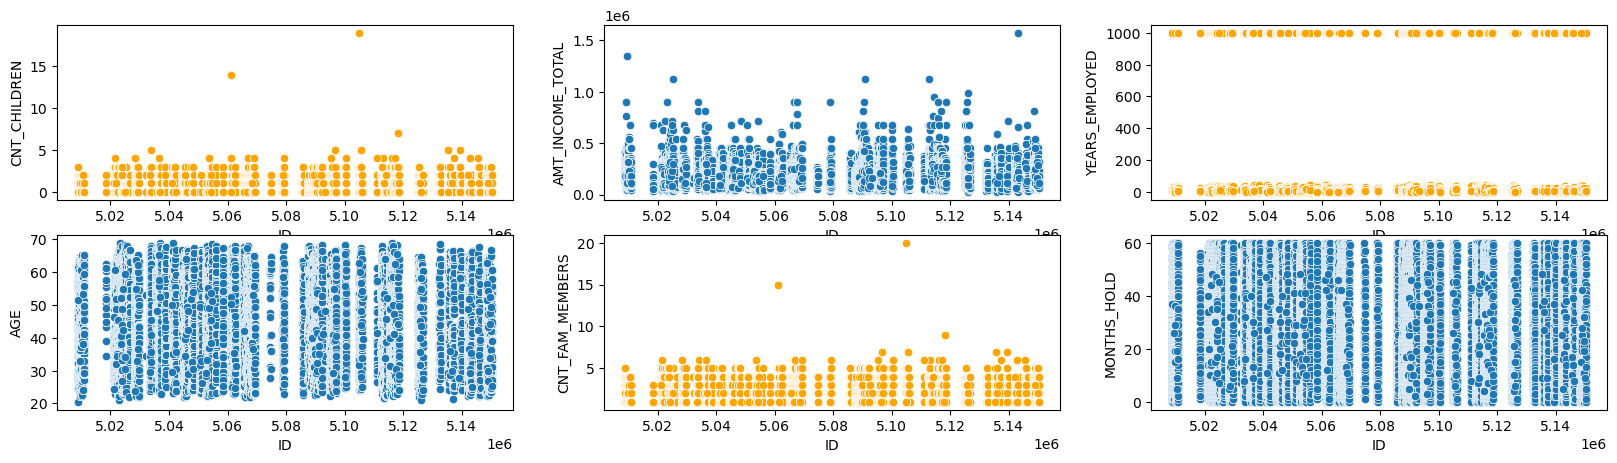

In [30]:
# check outlier in continuous features
fig, ax= plt.subplots(nrows= 2, ncols = 3, figsize= (20,5))

sns.scatterplot(x="ID", y="CNT_CHILDREN", data=data, ax=ax[0][0], color= "orange")
sns.scatterplot(x="ID", y="AMT_INCOME_TOTAL", data=data, ax=ax[0][1])
sns.scatterplot(x="ID", y="YEARS_EMPLOYED", data=data, ax=ax[0][2], color="orange")
sns.scatterplot(x="ID", y="AGE", data=data, ax=ax[1][0])
sns.scatterplot(x="ID", y="CNT_FAM_MEMBERS", data=data, ax=ax[1][1], color= "orange")
sns.scatterplot(x="ID", y="MONTHS_HOLD", data=data, ax=ax[1][2])
plt.show()


There are outliers in 3 columns.

CNT_CHILDREN
AMT_INCOME_TOTAL
CNT_FAM_MEMBERS

We need to remove these outliers to make sure they do not affect our model results.


In [31]:
# Outlier Romeval # 68-95-99.7 rule
# CNT_CHILDREN  
q_h = data["CNT_CHILDREN"].quantile(0.9973)
q_l = data["CNT_CHILDREN"].quantile(0.0027)
data = data[(data["CNT_CHILDREN"]>=q_l) & (data["CNT_CHILDREN"]<=q_h)]
#%%
# AMT_INCOME_TOTA
q_h = data["AMT_INCOME_TOTAL"].quantile(0.9973)
q_l = data["AMT_INCOME_TOTAL"].quantile(0.0027)
data= data[(data["AMT_INCOME_TOTAL"]>=q_l) & (data["AMT_INCOME_TOTAL"]<=q_h)]
#%%
# CNT_FAM_MEMBERS
q_h = data["CNT_FAM_MEMBERS"].quantile(0.9973)
q_l = data["CNT_FAM_MEMBERS"].quantile(0.0027)
data= data[(data["CNT_FAM_MEMBERS"]>=q_l) & (data["CNT_FAM_MEMBERS"]<=q_h)]


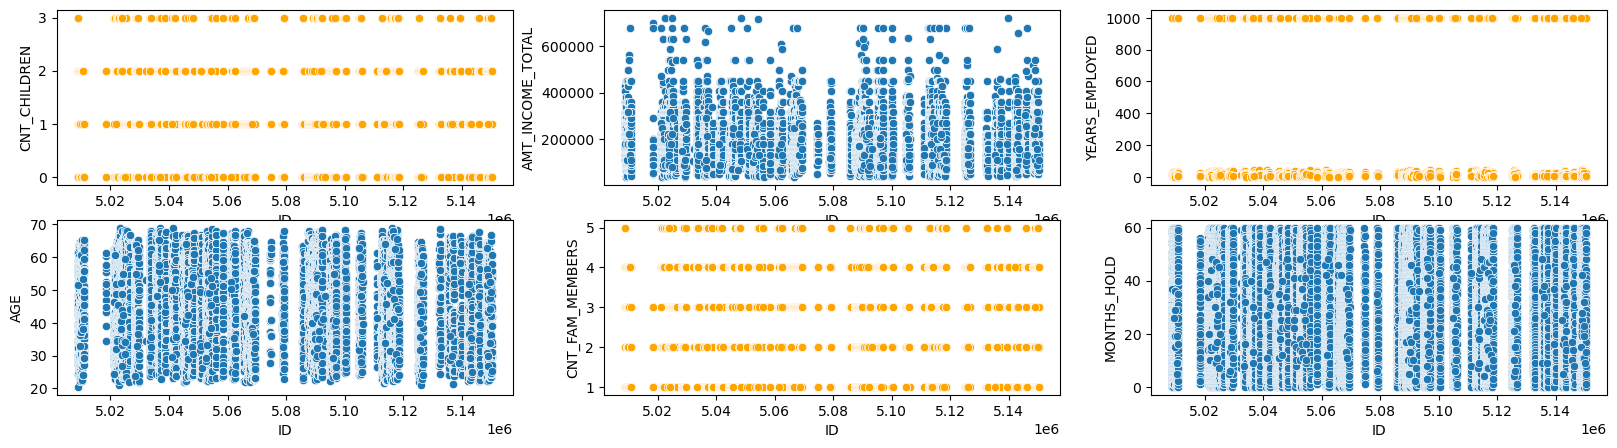

In [32]:
# check continuous features angain
fig, ax= plt.subplots(nrows= 2, ncols = 3, figsize= (20,5))

sns.scatterplot(x="ID", y="CNT_CHILDREN", data=data, ax=ax[0][0], color= "orange")
sns.scatterplot(x="ID", y="AMT_INCOME_TOTAL", data=data, ax=ax[0][1])
sns.scatterplot(x="ID", y="YEARS_EMPLOYED", data=data, ax=ax[0][2], color="orange")
sns.scatterplot(x="ID", y="AGE", data=data, ax=ax[1][0])
sns.scatterplot(x="ID", y="CNT_FAM_MEMBERS", data=data, ax=ax[1][1], color= "orange")
sns.scatterplot(x="ID", y="MONTHS_HOLD", data=data, ax=ax[1][2])
plt.show()

In [34]:
# count the num of missing values
missing=data.isnull().sum().reset_index().rename(columns={0:"missNum"})
# calculate proportion
missing["missRate"]=missing["missNum"]/data.shape[0]
# sort the attributes by missing rate
miss_analy=missing[missing.missRate>0].sort_values(by="missRate",ascending=False)
miss_analy
# Since there are less missing value,  we dont need to handle the missing value

,index,missNum,missRate
14,OCCUPATION_TYPE,4489,0.140734


In [68]:
data.head(10)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,MONTHS_HOLD,TARGET,YEARS_EMPLOYED,AGE
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,1,1,0,0,NaN,2.0,15,1,12.44,32.89
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,1,1,0,0,NaN,2.0,14,1,12.44,32.89
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,1,0,0,0,Security staff,2.0,29,1,3.11,58.83
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,1,0,1,1,Sales staff,1.0,4,1,8.36,52.36
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,1,0,1,1,Sales staff,1.0,26,1,8.36,52.36
6,5008811,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,1,0,1,1,Sales staff,1.0,38,1,8.36,52.36
7,5008812,F,N,Y,0,283500.0,Pensioner,Higher education,Separated,House / apartment,1,0,0,0,Unemployed,1.0,20,1,1000.67,61.55
8,5008813,F,N,Y,0,283500.0,Pensioner,Higher education,Separated,House / apartment,1,0,0,0,Unemployed,1.0,16,1,1000.67,61.55
9,5008814,F,N,Y,0,283500.0,Pensioner,Higher education,Separated,House / apartment,1,0,0,0,Unemployed,1.0,17,1,1000.67,61.55
10,5008815,M,Y,Y,0,270000.0,Working,Higher education,Married,House / apartment,1,1,1,1,Accountants,2.0,5,1,2.11,46.22


### 3.1 Importance Features

In [67]:
import os
import pandas as pd
import numpy as np
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import re
import traceback
import string
max_bin = 20
force_bin = 3

# define a binning function
def mono_bin(Y, X, n = max_bin):
    
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1 
        except Exception as e:
            n = n - 1

    if len(d2) == 1:
        n = force_bin         
        bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)

def char_bin(Y, X):
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]    
    df2 = notmiss.groupby('X',as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)
    
    return(d3)

def data_vars(df1, target):
    
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    
    for i in x:
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 2:
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i            
                count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv)
#%%
df = data.drop(['ID'], axis=1)
final_iv, IV = data_vars(df,df.TARGET)

IV_value = IV.sort_values('IV',ascending=False)
print(IV_value)

<ipython-input-67-522978a11b7c>:91: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
<ipython-input-67-522978a11b7c>:92: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT


               VAR_NAME        IV
0                   AGE  3.936310
17       YEARS_EMPLOYED  2.448059
16      OCCUPATION_TYPE  0.206295
15     NAME_INCOME_TYPE  0.106995
13   NAME_FAMILY_STATUS  0.093270
5            FLAG_EMAIL  0.054120
2          CNT_CHILDREN  0.041554
11          MONTHS_HOLD  0.036088
4           CODE_GENDER  0.029045
12  NAME_EDUCATION_TYPE  0.021888
14    NAME_HOUSING_TYPE  0.010758
10      FLAG_WORK_PHONE  0.009467
7          FLAG_OWN_CAR  0.008420
9            FLAG_PHONE  0.006651
3       CNT_FAM_MEMBERS  0.004095
1      AMT_INCOME_TOTAL  0.002041
8       FLAG_OWN_REALTY  0.000123
6            FLAG_MOBIL  0.000000


C:\Users\Chan Yuk Yee\anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


### 3.2 Exploratory data analysis

In [35]:
def bad_cust_proportion(col) :
    bad_prop_cnt = data.groupby([col,'TARGET']).agg({'ID': 'count'})
    bad_prop_percent = bad_prop_cnt.groupby(level=0).apply(lambda x:100 * x / float(x.sum()))
    return bad_prop_percent

In [36]:

print(bad_cust_proportion('NAME_EDUCATION_TYPE'))

# Lower secondary 0.6 & Incomplete higher 0.4--> Bad

                                              ID
NAME_EDUCATION_TYPE           TARGET            
Academic degree               1       100.000000
Higher education              0         0.373439
                              1        99.626561
Incomplete higher             0         0.403226
                              1        99.596774
Lower secondary               0         0.613497
                              1        99.386503
Secondary / secondary special 0         0.289828
                              1        99.710172


In [37]:
print(bad_cust_proportion('NAME_FAMILY_STATUS'))
# Single customers have a higher proportion of bad customers as compared to married customers
# Single / not married 0.49 & Widow 0.44 --> Bad

                                    ID
NAME_FAMILY_STATUS   TARGET           
Civil marriage       0        0.115163
                     1       99.884837
Married              0        0.302018
                     1       99.697982
Separated            0        0.325910
                     1       99.674090
Single / not married 0        0.494933
                     1       99.505067
Widow                0        0.442804
                     1       99.557196


### 4. Feature encoding

In [38]:
df = data
df = df.drop(['ID'], axis=1)
#Convert binary categorical columns to have integer value
df['CODE_GENDER'] = df.CODE_GENDER.apply(lambda x : 0 if x == 'M' else 1)

In [39]:
#Convert binary categorical columns to have integer value
df['CODE_GENDER'] = df.CODE_GENDER.apply(lambda x : 0 if x == 'M' else 1)
df['FLAG_OWN_CAR'] = df.FLAG_OWN_CAR.apply(lambda x : 0 if x == 'N' else 1)
df['FLAG_OWN_REALTY'] = df.FLAG_OWN_REALTY.apply(lambda x : 0 if x == 'N' else 1)

In [40]:
# ["NAME_INCOME_TYPE","NAME_EDUCATION_TYPE","NAME_EDUCATION_TYPE","NAME_HOUSING_TYPE","OCCUPATION_TYPE","NAME_FAMILY_STATUS"]
X = df.drop(['TARGET'], axis=1).values
Y = df.iloc[ : , -3].values  
#%%
Col = [5,6,7,8,13]
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
labelencoder_X = LabelEncoder()
for c in Col:
    X[ : , c] = labelencoder_X.fit_transform(X[ : , c])
#%%
# creating a dummy variable 

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
ct = ColumnTransformer([('onehotencoder', OneHotEncoder(), [5])], remainder = 'passthrough')
X = ct.fit_transform(X) 
#%%
ct = ColumnTransformer([('onehotencoder', OneHotEncoder(), [10])], remainder = 'passthrough')
X = ct.fit_transform(X) 
#%%
ct = ColumnTransformer([('onehotencoder', OneHotEncoder(), [15])], remainder = 'passthrough')
X = ct.fit_transform(X)
#%%
ct = ColumnTransformer([('onehotencoder', OneHotEncoder(), [20])], remainder = 'passthrough')
X = ct.fit_transform(X) 
#%%
ct = ColumnTransformer([('onehotencoder', OneHotEncoder(), [30])], remainder = 'passthrough')
X = ct.fit_transform(X) 

### 4. Modeling

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, recall_score

In [44]:
# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, Y,  test_size=0.3, random_state = 5)


In [45]:
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
X_scaled = mms.fit_transform(X_train)
X_test_scaled = mms.transform(X_test)
# we have now fit and transform the data into a scaler for accurate reading and results.

In [46]:
# Handle imbalance data
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X_scaled=np.array(X_scaled)
X_test_scaled=np.array(X_test_scaled)
X_balanced, y_balanced = oversample.fit_resample(X_scaled, y_train)
X_test_balanced, y_test_balanced = oversample.fit_resample(X_test_scaled, y_test)
# we have addressed the issue of oversampling here

In [72]:
"""
We notice in the value counts above that label types are now balanced
the problem of oversampling is solved now
we will now implement different models to see which one performs the best"""

'\nWe notice in the value counts above that label types are now balanced\nthe problem of oversampling is solved now\nwe will now implement different models to see which one performs the best'

#### LogisticRegression

In [47]:
from sklearn.linear_model import LogisticRegression
log = LogisticRegression()
model = log.fit(X_balanced, y_balanced)
y_pre = log.predict(X_test_balanced)

C:\Users\Chan Yuk Yee\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [48]:
from sklearn.metrics import classification_report
print(classification_report(y_test_balanced, y_pre))

              precision    recall  f1-score   support

           0       0.56      0.37      0.44      9536
           1       0.53      0.71      0.61      9536

    accuracy                           0.54     19072
   macro avg       0.54      0.54      0.52     19072
weighted avg       0.54      0.54      0.52     19072



In [49]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test_balanced, y_pre))

[[3481 6055]
 [2759 6777]]


#### SVC

In [54]:
from sklearn.svm import SVC
svm = SVC()
model = svm.fit(X_balanced, y_balanced)
y_pre = svm.predict(X_test_balanced)

In [55]:
print(classification_report(y_test_balanced, y_pre))

              precision    recall  f1-score   support

           0       0.97      0.62      0.76      9536
           1       0.72      0.98      0.83      9536

    accuracy                           0.80     19072
   macro avg       0.84      0.80      0.79     19072
weighted avg       0.84      0.80      0.79     19072



In [56]:
print(confusion_matrix(y_test_balanced, y_pre))

[[5950 3586]
 [ 209 9327]]


In [109]:
 aaa.columns=my_list
aaa



,ll0,ll1,ll2,ll3,ll4,ll5,ll6,ll7,ll8,ll9,...,ll42,ll43,ll44,ll45,ll46,ll47,ll48,ll49,ll50,ll51
TARGET,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.000000,0.049419,0.0,0.0,1.0,0.000000,0.200000,...,0.0,0.000000,0.0,0.000000,1.0,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.000000,0.069767,0.0,0.0,1.0,0.000000,0.200000,...,0.0,0.000000,0.0,0.000000,1.0,0.000000,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.200000,0.133721,0.0,0.0,0.0,0.000000,0.200000,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.200000,0.200581,0.0,0.0,0.0,1.000000,0.400000,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.000000,0.034884,0.0,1.0,1.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.0,0.0,0.0,0.000000,0.098837,0.0,0.0,0.0,0.000000,0.200000,...,0.0,0.000000,0.0,0.000000,1.0,0.000000,1.0,0.0,0.0,0.0
0,0.0,0.0,0.0,0.112113,0.103464,0.0,1.0,1.0,0.000000,0.312113,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,1.0,0.0,0.0,0.0
0,0.0,0.0,0.0,0.021449,0.052115,0.0,0.0,0.0,0.107246,0.221449,...,0.0,0.000000,0.0,0.892754,0.0,0.107246,1.0,0.0,0.0,0.0


In [107]:
my_list = []
for i in range(0, 52):
  my_list.append("ll"+str(i))
my_list

['ll0',
 'll1',
 'll2',
 'll3',
 'll4',
 'll5',
 'll6',
 'll7',
 'll8',
 'll9',
 'll10',
 'll11',
 'll12',
 'll13',
 'll14',
 'll15',
 'll16',
 'll17',
 'll18',
 'll19',
 'll20',
 'll21',
 'll22',
 'll23',
 'll24',
 'll25',
 'll26',
 'll27',
 'll28',
 'll29',
 'll30',
 'll31',
 'll32',
 'll33',
 'll34',
 'll35',
 'll36',
 'll37',
 'll38',
 'll39',
 'll40',
 'll41',
 'll42',
 'll43',
 'll44',
 'll45',
 'll46',
 'll47',
 'll48',
 'll49',
 'll50',
 'll51']

<AxesSubplot:xlabel='ll3', ylabel='ll20'>

C:\Users\limlim1\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


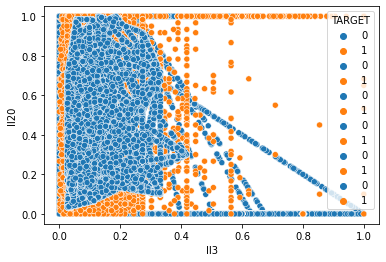

In [131]:


sns.scatterplot(x="ll3",y="ll20",data=aaa,hue=aaa.index)



<AxesSubplot:xlabel='ll2', ylabel='ll4'>

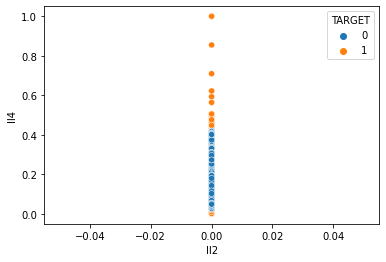

In [132]:
sns.scatterplot(x="ll2",y="ll4",data=aaa,hue=aaa.index)

<AxesSubplot:xlabel='ll12', ylabel='ll30'>

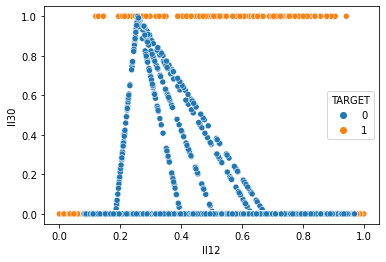

In [133]:
sns.scatterplot(x="ll12",y="ll30",data=aaa,hue=aaa.index)

<AxesSubplot:xlabel='ll40', ylabel='ll50'>

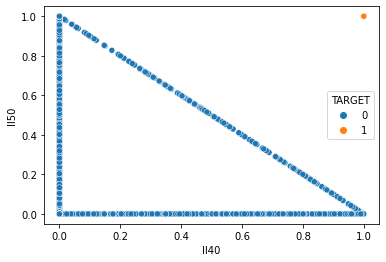

In [134]:
sns.scatterplot(x="ll40",y="ll50",data=aaa,hue=aaa.index)

<AxesSubplot:xlabel='ll3', ylabel='ll46'>

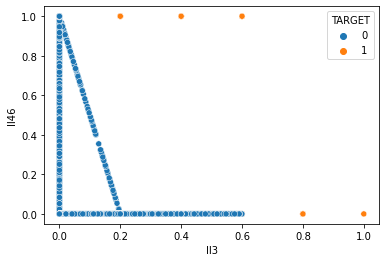

In [135]:
sns.scatterplot(x="ll3",y="ll46",data=aaa,hue=aaa.index)

<AxesSubplot:xlabel='ll4', ylabel='ll10'>

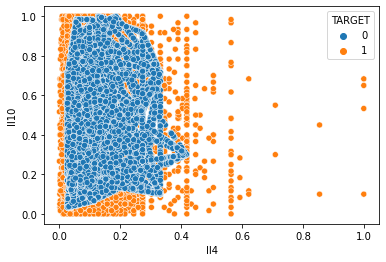

In [136]:
sns.scatterplot(x="ll4",y="ll10",data=aaa,hue=aaa.index)

In [130]:
aaa['ll51'].describe()

count    47988.000000
mean         0.041353
std          0.188325
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: ll51, dtype: float64

#### XGBoost

In [60]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
model = xgb.fit(X_balanced, y_balanced)
y_pre = xgb.predict(X_test_balanced)

C:\Users\Chan Yuk Yee\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:27:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [61]:
print(classification_report(y_test_balanced, y_pre))

              precision    recall  f1-score   support

           0       1.00      0.86      0.93      9536
           1       0.88      1.00      0.93      9536

    accuracy                           0.93     19072
   macro avg       0.94      0.93      0.93     19072
weighted avg       0.94      0.93      0.93     19072



In [62]:
print(confusion_matrix(y_test_balanced, y_pre))


[[8219 1317]
 [   8 9528]]


#### K-fold cross

In [63]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(xgb,X_balanced, y_balanced,cv=10,scoring='accuracy')
print(scores)
print(scores.mean())

C:\Users\Chan Yuk Yee\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:28:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Chan Yuk Yee\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:28:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Chan Yuk Yee\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:28:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Chan Yuk Yee\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:28:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Chan Yuk Yee\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:28:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Chan Yuk Yee\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:28:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Chan Yuk Yee\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:28:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Chan Yuk Yee\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:28:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Chan Yuk Yee\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:28:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Chan Yuk Yee\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0.98899371 1.         0.99955076 0.99977538 0.99977538 0.99932615
 0.99910153 0.99977538 0.99932599 0.99932599]
0.9984950281219298


In [54]:
X_balanced

NameError: name 'X_balanced' is not defined

In [19]:
data2

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,MONTHS_HOLD,TARGET,YEARS_EMPLOYED,AGE
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,1,1,0,0,NaN,2.0,15,1,12.44,32.89
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,1,1,0,0,NaN,2.0,14,1,12.44,32.89
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,1,0,0,0,Security staff,2.0,29,1,3.11,58.83
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,1,0,1,1,Sales staff,1.0,4,1,8.36,52.36
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,1,0,1,1,Sales staff,1.0,26,1,8.36,52.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36452,5149828,M,Y,Y,0,315000.0,Working,Secondary / secondary special,Married,House / apartment,1,0,0,0,Managers,2.0,11,0,6.63,47.53
36453,5149834,F,N,Y,0,157500.0,Commercial associate,Higher education,Married,House / apartment,1,0,1,1,Medicine staff,2.0,23,1,3.63,33.94
36454,5149838,F,N,Y,0,157500.0,Pensioner,Higher education,Married,House / apartment,1,0,1,1,Medicine staff,2.0,32,1,3.63,33.94
36455,5150049,F,N,Y,0,283500.0,Working,Secondary / secondary special,Married,House / apartment,1,0,0,0,Sales staff,2.0,9,0,1.79,49.20


In [23]:
oog=data2

In [30]:

oog.replace(to_replace ="N",
                 value ="0",inplace=True)

In [46]:
a=oog['AMT_INCOME_TOTAL']

In [49]:
b=a/100000

In [50]:
aag=oog

In [51]:
aag['AMT_INCOME_TOTAL']=b

<ipython-input-51-9f0081c6a984>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aag['AMT_INCOME_TOTAL']=b


In [52]:
aag

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,MONTHS_HOLD,TARGET,YEARS_EMPLOYED,AGE
0,5008804,1,1,1,0,4.275,Working,Higher education,Civil marriage,Rented apartment,1,1,0,0,NaN,2.0,15,1,12.44,32.89
1,5008805,1,1,1,0,4.275,Working,Higher education,Civil marriage,Rented apartment,1,1,0,0,NaN,2.0,14,1,12.44,32.89
2,5008806,1,1,1,0,1.125,Working,Secondary / secondary special,Married,House / apartment,1,0,0,0,Security staff,2.0,29,1,3.11,58.83
3,5008808,0,0,1,0,2.700,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,1,0,1,1,Sales staff,1.0,4,1,8.36,52.36
4,5008809,0,0,1,0,2.700,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,1,0,1,1,Sales staff,1.0,26,1,8.36,52.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36452,5149828,1,1,1,0,3.150,Working,Secondary / secondary special,Married,House / apartment,1,0,0,0,Managers,2.0,11,0,6.63,47.53
36453,5149834,0,0,1,0,1.575,Commercial associate,Higher education,Married,House / apartment,1,0,1,1,Medicine staff,2.0,23,1,3.63,33.94
36454,5149838,0,0,1,0,1.575,Pensioner,Higher education,Married,House / apartment,1,0,1,1,Medicine staff,2.0,32,1,3.63,33.94
36455,5150049,0,0,1,0,2.835,Working,Secondary / secondary special,Married,House / apartment,1,0,0,0,Sales staff,2.0,9,0,1.79,49.20


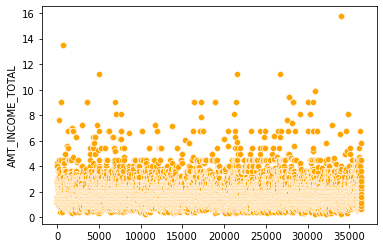

Int64Index([    0,     1,     2,     3,     4,     6,     7,     8,     9,
               10,
            ...
            36447, 36448, 36449, 36450, 36451, 36452, 36453, 36454, 36455,
            36456],
           dtype='int64', length=32103)

In [53]:

#sns.scatterplot(x="CNT_CHILDREN", y="AMT_INCOME_TOTAL", data=oog, color= "orange")
sns.scatterplot(x=oog.index, y="AMT_INCOME_TOTAL", data=aag, color= "orange")
#sns.scatterplot(x="ID", y="AMT_INCOME_TOTAL", data=data2, ax=ax[0][1])
#sns.scatterplot(x="ID", y="YEARS_EMPLOYED", data=data2, ax=ax[0][2], color="orange")
#sns.scatterplot(x="ID", y="AGE", data=data2, ax=ax[1][0])
#sns.scatterplot(x="ID", y="CNT_FAM_MEMBERS", data=data2, ax=ax[1][1], color= "orange")
#sns.scatterplot(x="ID", y="MONTHS_HOLD", data=data2, ax=ax[1][2])
plt.show()
oog.index